In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os
import random

In [3]:
import numpy as np
import cv2
from mpl_toolkits.mplot3d import Axes3D

# Create thresholded binary image
def makeGrayImg(img, mask=None, colorspace='rgb', useChannel=0):
    '''
    Returns a grey image based on the following inputs
    - mask
    - choice of color space
    - choice of channel(s) to use
    '''
    # color space conversion
    if colorspace == 'gray':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGRGRAY)
    elif colorspace == 'hsv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'hls':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'lab':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif colorspace == 'luv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif colorspace == 'yuv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    else: 
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # isolate channel
    if colorspace != 'gray':
        cvt_img = cvt_img[:,:,useChannel]     

    # apply image mask
    if mask is not None:
        imgMask = np.zeros_like(cvt_img)    
        ignore_mask_color = 255
        # filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(imgMask, mask, ignore_mask_color)
        # returning the image only where mask pixels are nonzero
        cvt_img = cv2.bitwise_and(cvt_img, imgMask)
    return cvt_img


def scaleImgValues(img, maxVal=None):
    if maxVal==None:
        maxVal=np.max(img)
    return np.uint8(255*img/maxVal)


def writeImg(img, outFile, binary=False):
    if binary:
        # scale to 8-bit (0 - 255)
        img = np.uint8(255*img)
    cv2.imwrite(outFile, img)
    

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax  # return Axes3D object for further manipulation


def get_color_features(img, color_space='BGR', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features


def get_colorHist_features(img, nbins=32, bins_range=(0, 256)):
    '''
    returns feature vector of all single channel histograms of the image
    note: feature vector from greyscale image will be 1/3 the size of the feature vector of a color image
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    if img.shape[2] != 0:
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else:
        features = channel1_hist[0]    
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [4]:
vehicleFolder = 'data/vehicles'
nonVehicleFolder = 'data/non-vehicles'
file_types = ('jpg', 'png')

In [5]:
# read in and count datasets
files_vehicle = []
files_nonVehicle = []
for ext in file_types:
    files_vehicle.extend(glob.glob('{}/**/*.{}'.format(vehicleFolder, ext), recursive=True))
    files_nonVehicle.extend(glob.glob('{}/**/*.{}'.format(nonVehicleFolder, ext), recursive=True))

img = cv2.imread(files_vehicle[0])
imgShape = img.shape
print('There are {} car and {} non-car images with shape {}'.format(len(files_vehicle), len(files_nonVehicle), imgShape))

There are 8792 car and 8968 non-car images with shape (64, 64, 3)


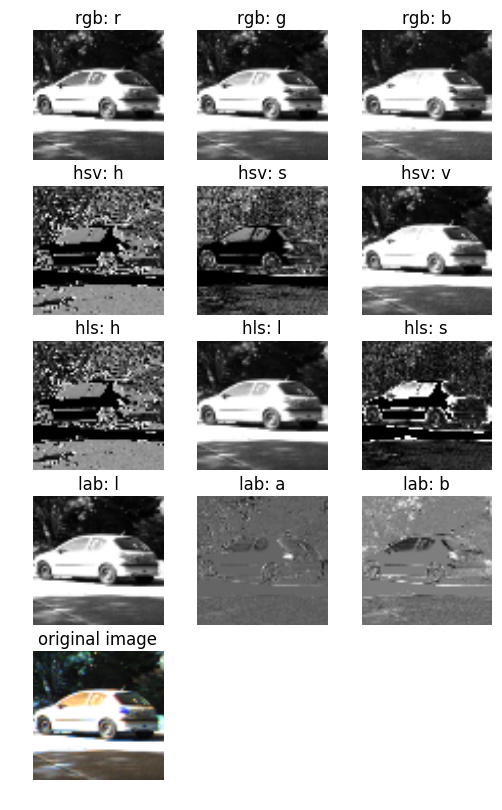

In [6]:
rand = random.randint(0, len(files_vehicle)-1)
img = cv2.imread(files_vehicle[rand])

color_spaces = ('rgb', 'hsv', 'hls', 'lab')
fig = plt.figure()
subplot_i = 1

# visualize different color channels
for clrSpace in color_spaces:
    for channel in range(3):
        cvtImg = makeGrayImg(img, mask=None, colorspace=clrSpace, useChannel=channel)
        plt.subplot(5,3,subplot_i)
        plt.imshow(cvtImg, cmap='gray')
        plt.subplots_adjust(top=2.00)
        plt.axis('off')
        plt.title('{}: {}'.format(clrSpace, clrSpace[channel]))
        subplot_i +=1

plt.subplot(5,3,subplot_i)
plt.imshow(img)
plt.axis('off')
plt.title('original image')

plt.show()
# visualize HOG



In [44]:
img = cv2.imread(files_vehicle[0])
img = makeGrayImg(img, mask=None, colorspace=clrSpace, useChannel=channel)

0
1
2
